# Perform online segmentation

In [1]:
%cd ../dev/
from dataset_creation_aprovis3d import aprovis3dDataset
from hots.utils import get_loader, fit_mlr, online_accuracy

/home/INT/grimaldi.a/Documents/projets/HOTS/aprovhots/dev


In [2]:
#!/usr/bin/env python
# coding: utf-8

# # Make a [tonic](https://tonic.readthedocs.io/en/latest/) dataset - see [documentation](https://tonic.readthedocs.io/en/latest/tutorials/wrapping_own_data.html)
# ## Example with the RGB frames dataset provided by NTUA, translated by UCA into events using vid2e

import sys
sys.path.append('../dev/')
from dataset_creation_aprovis3d import aprovis3dDataset
from hots.utils import get_dataset_info


# path where you'll go to find your .npy files to make the dataset with
### TO BE MODIFIED
path = '../../Data/DVS128_ZED_NUC_jAER/'
# gives the data type - here we use experimental data, stored as npy
data_type = 'experimental'
# gives a patch_size to divide spatially the event streams
patch_size = (16,16)
# gives a max duration for the samples of the dataset to divide temporally the event streams
max_duration = 1e3 # (in ms)
# labels given to the different classes of the dataset
labelz = ['sea','gro']
# original sensor_size of the DVS (width,height,polarity)
sensor_size = [128, 128, 2]
# discard samples with less than min_num_events events
min_num_events = 1000
# split the recordings into train and test sets with train_test_ratio ratio
train_test_ratio = .75
# gives the indexing of the event stream
ordering = 'xytp'

trainset = aprovis3dDataset(save_to=path, data_type=data_type, classes=labelz, train=True, patch_size=patch_size, max_duration=max_duration, sensor_size=sensor_size)

## Example with only one layer of Multinomial Logistic Regression (MLR)

In [3]:
jitter = (None, None)
num_workers = 0
learning_rate = 0.005
betas = (0.9, 0.999)
num_epochs = 2 ** 5 + 1
N_polarities = 2
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_polarities)
tau_cla = 6e4
date = '2022-05-18'
mlr_layer_name = f'{date}_LR_{tau_cla}_{ts_size}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'

model_path = '../Records/networks/' + mlr_layer_name
results_path = f'../Records/LR_results/' + mlr_layer_name

trainloader = get_loader(trainset, kfold=2)
classif_layer, losses = fit_mlr(trainloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes))

Number of chance decisions: 0
90th quantile for number of events: 2640.4
Mean accuracy: 77.9%
Last accuracy: 50.9%
Highest probability accuracy: 57.49999999999999%


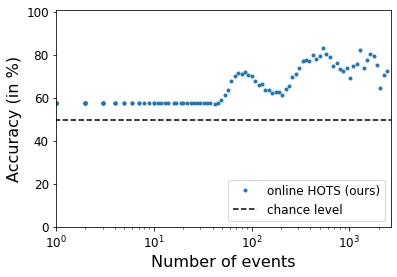

In [4]:
testloader = get_loader(trainset, kfold=2, kfold_ind=1)

mlr_threshold = None
ts_batch_size = None

#results_path = results_path[:-4]+'trainset.pkl'

onlinac = online_accuracy(classif_layer, tau_cla, testloader, results_path, ts_size, trainset.ordering, len(labelz), mlr_threshold = mlr_threshold, ts_batch_size = ts_batch_size, original_accuracy = None, original_accuracy_nohomeo = None, online_plot=True)

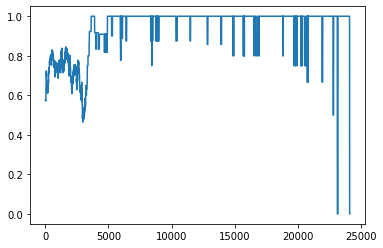

In [5]:
import matplotlib.pyplot as plt
plt.plot(onlinac[0])

In [6]:
print(results_path[:-4])

../Records/LR_results/2022-05-18_LR_60000.0_(16, 16, 2)_0.005_(0.9, 0.999)_33_(None, None)
